In [24]:
import pathlib
import json

# data
import xarray
import numpy as np
import pandas as pd

# plotting
import cmocean.cm
import matplotlib
import matplotlib.pyplot as plt
import osgeo.osr

from matplotlib.colors import LinearSegmentedColormap      


# 3d
from tvtk.api  import tvtk
from mayavi import mlab


In [6]:
#  A python  implementation of the Web Mercator version  of mapbox
earth_radius = 6371008.8
earth_circumfrence = 2 * np.pi * earth_radius

def lat_from_mercator_y(y):
    y2 = 180 - y * 360
    return 360 / np.pi * np.arctan(np.exp(y2 * np.pi / 180)) - 90


def mercator_scale(lat):
    return 1 / np.cos(lat * np.pi / 180)

def meter_in_mercator_coordinate_units(y):
    return 1 / earth_circumfrence * mercator_scale(lat_from_mercator_y(y))


def mercator_y_from_lat(lat):
    return (180 - (180 / np.pi * np.log(np.tan(np.pi / 4 + lat * np.pi / 360)))) / 360


def mercator_x_from_lng(lng):
    return (180 + lng) / 360

def circumference_at_latitude(latitude):
    return earth_circumfrence * np.cos(latitude * np.pi / 180)

def mercator_z_from_altitude(altitude, lat):
    return altitude / circumference_at_latitude(lat)


def scale_at_lat(lat):
    meter_at_lat = meter_in_mercator_coordinate_units(mercator_y_from_lat(lat))
    meter_at_0 = meter_in_mercator_coordinate_units(mercator_y_from_lat(0))
    return meter_at_lat / meter_at_0




In [11]:
data_dir = pathlib.Path('~/data/odv/public/climatology/').expanduser()
ds_paths = list(data_dir.expanduser().glob('*1.1/*.nc'))

wgs84 = osgeo.osr.SpatialReference()
webmercator = osgeo.osr.SpatialReference()
wgs84.ImportFromEPSG(4326)
webmercator.ImportFromEPSG(3857)
wgs2wm =  osgeo.osr.CoordinateTransformation(wgs84, webmercator)

In [12]:


def latlng2mapbox(lat, lon, z=None):

    # compute the extent of the web mercator projection
    rad_max = 2 * np.arctan(np.exp(np.pi)) - (np.pi / 2)
    deg_max = np.rad2deg(rad_max)
    _, y_max, _ = wgs2wm.TransformPoint(deg_max,  0)

    if z is None:
        z = np.zeros_like(lat)
    latlonz = np.c_[lat, lon, z]
    xyz_3857 = np.array(wgs2wm.TransformPoints(latlonz))
    # rescale to 0, 0 - 1, 1
    xyz_mapbox = (xyz_3857 / (y_max * 2)) + 0.5
    # with y flipped
    xyz_mapbox[:, 1] = 1 - xyz_mapbox[:, 1]
    xyz_mapbox[:, 2] = xyz_3857[:, 2] 
    return xyz_mapbox

def test_latlng2mapbox():
    #  Testing the conversion  to mapbox coordinates
    helsinki = {
        "lng": 25.004,
        "lat": 60.239
    }
    berlin = {
        "lng": 13.403,
        "lat": 52.562
    }
    kyiv = {
        "lng": 30.498,
        "lat": 50.541
    }

    zero = {
        'lng': 0,
        "lat": 0
    }


    helsinki['x'] = 0.5694555555555555
    helsinki['y'] = 0.28906703939214295

    berlin['x'] = 0.5372305555555555
    berlin['y'] = 0.3277633358931997

    kyiv['x'] = 0.5847166666666667
    kyiv['y'] = 0.33679357865410225

    zero['x'] = 0.5
    zero['y'] = 0.5

    #  validate our projection method
    for obj in [helsinki, berlin, kyiv, zero]:
        obj['xyz_3857'] = np.array(wgs2wm.TransformPoint(obj['lat'], obj['lng']))
        obj['xyz_mapbox'] = latlng2mapbox(obj['lat'], obj['lng'])
        assert np.allclose(np.squeeze(obj['xyz_mapbox'])[:2], [obj['x'], obj['y']])
        
        
# test that we get correct coordinates
test_latlng2mapbox()
        



In [13]:
def compute_contours(ds_path, variable='Salinity', percentiles=None):
    """compute a set  of contours for a dataset"""
    ds = xarray.open_dataset(ds_path)
    
    
    # guess the names 
    # not generic, but input data is not well defined
    # multiple lat/lon in one file
    # standard names not always filled in
    
    # or get variables from grid variable 
    var = getattr(ds, variable)

    try:
        lat = getattr(var, 'lat')
    except AttributeError:
        lat = getattr(var, 'latitude')
    try:
        lon = getattr(var, 'lon')
    except AttributeError:
        lon = getattr(var, 'longitude')
    
    try: 
        height = getattr(var, 'depth')
    except AttributeError:
        height = getattr(var, 'altitude')
    
    # if positive is down, switch to up
    if getattr(height, 'positive', 'up') == 'down':
        height = height.values * -1
    else:
        height = height.values
    
    meta = {}
    meta['path'] = str(ds_path)
    
    # Lookup index of time dimension and average over it
    

    # Lookup array with values
    arr = np.squeeze(var.mean(dim='time').values)

    # lookup extent of values
    var_min = np.nanmin(arr)
    var_max = np.nanmax(arr)

    # define  percentiles
    q = [1, 25,  50,  75, 99]
    q = [5, 95]
    if percentiles  is None:
        percentiles = np.nanpercentile(arr, q)

    
    meta['variable'] = variable
    meta['var_min'] = var_min
    meta['var_max'] = var_max
    meta['percentiles'] = percentiles.tolist()

    # change dimenions  to x,y,z
    # This assumes data are in z, lat, lon
    arr = np.moveaxis(arr, [0, 1, 2], [2, 1, 0])

    # deal with missing data
    arr_masked = np.ma.masked_invalid(arr)
    
    # create gridded coordinates
    Lat, Lon, Z = np.meshgrid(lat.values, lon.values, height)
    

    # Tranform to mapbox coordinates
    xyz = latlng2mapbox(Lat.ravel(), Lon.ravel(), Z.ravel())
    
    print(xyz.min(axis=0))
    print(xyz.max(axis=0))
    
    
    X = xyz[:, 0].reshape(Lon.shape)
    Y = xyz[:, 1].reshape(Lat.shape)
    
    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)
    z_min, z_max = np.min(Z), np.max(Z)
    
    lat_min, lat_max = Lat.min(), Lat.max()
    lon_min, lon_max = Lon.min(), Lon.max()
    
    meta['x_min'] = x_min
    meta['x_max'] = x_max
    meta['y_min'] = y_min
    meta['y_max'] = y_max
    meta['z_min'] = z_min
    meta['z_max'] = z_max
    meta['lat_min'] = lat_min
    meta['lat_max'] = lat_max
    meta['lon_min'] = lon_min
    meta['lon_max'] = lon_max
    
    # TODO: replace by Rectilinear Grid
    grid =  tvtk.StructuredGrid(dimensions=X.shape[::-1])
    # TODO use arr_masked.mask to "blank out points"
    grid.points = xyz

    point_mask = arr_masked.mask
    # get the indices where the array is masked
    point_idxs, = np.where(point_mask.ravel())
    # blank out the cells
    for point_idx in point_idxs:
        grid.blank_point(point_idx)
    
    cell_mask = arr_masked.mask 
    cell_mask = np.logical_or(cell_mask[:-1, :, :], cell_mask[1:, :, :])
    cell_mask = np.logical_or(cell_mask[:, :-1, :], cell_mask[:, 1:, :])
    cell_mask = np.logical_or(cell_mask[:, :, :-1], cell_mask[:, :, 1:])

    # get the indices where the array is masked
    cell_idxs, = np.where(cell_mask.ravel())
    # blank out the cells
    for cell_idx in cell_idxs:
        grid.blank_cell(cell_idx)
    
    
    
    grid.point_data.scalars = arr_masked.ravel()
    grid.point_data.scalars.name = 'scalars'
    grid.modified()
        
    vtk_path = ds_path.with_suffix('.vtk')
    writer = tvtk.DataSetWriter(file_name=str(vtk_path))
    writer.add_input_data_object(grid)
    writer.update()
    writer.write()
    
    contours = []
    for percentile in percentiles:
        contour =  tvtk.ContourFilter()
        contour.set_value(0, percentile)
        contour.set_input_data(grid)
        contour.use_scalar_tree =  True
        contour.compute_normals = True
        contour.update()
        # get rid of nan points
        clean = tvtk.CleanPolyData()
        clean.set_input_data(contour.output)
        clean.update()
        contours.append(clean.output)
    return meta, contours

In [14]:
rows = []
for ds_path in ds_paths:
    variable = None
    percentiles = None
    if 'Salinity' in str(ds_path):
        variable = 'Salinity'
        percentiles = np.array([31, 36])
    elif 'Temperature' in str(ds_path):
        variable = 'Temperature'        
        percentiles = np.array([10, 25])
    var = getattr(xarray.load_dataset(ds_path), variable)
    rows.append({'path': ds_path, 'var': variable, 'mean': var.mean().values, 'std': var.std().values})
rows        

[{'path': PosixPath('/Users/baart_f/data/odv/public/climatology/SDN_2015-11_TS_Arctic_Climatology_v1.1/Salinity.19002014.4Danl.nc'),
  'var': 'Salinity',
  'mean': array(34.741467, dtype=float32),
  'std': array(0.37769294, dtype=float32)},
 {'path': PosixPath('/Users/baart_f/data/odv/public/climatology/SDN_2015-11_TS_Arctic_Climatology_v1.1/Temperature.19002014.4Danl.nc'),
  'var': 'Temperature',
  'mean': array(2.531795, dtype=float32),
  'std': array(2.6788604, dtype=float32)},
 {'path': PosixPath('/Users/baart_f/data/odv/public/climatology/SDN_2015-11_TS_BlackSea_Climatology_v1.1/Temperature.4Danl.nc'),
  'var': 'Temperature',
  'mean': array(9.641233, dtype=float32),
  'std': array(3.325004, dtype=float32)},
 {'path': PosixPath('/Users/baart_f/data/odv/public/climatology/SDN_2015-11_TS_BlackSea_Climatology_v1.1/Salinity.4Danl.nc'),
  'var': 'Salinity',
  'mean': array(20.302895, dtype=float32),
  'std': array(1.9911157, dtype=float32)},
 {'path': PosixPath('/Users/baart_f/data/odv

In [15]:
# two degrees
results = []
for ds_path in ds_paths:
    variable = None
    percentiles = None
    if 'Salinity' in str(ds_path):
        variable = 'Salinity'
        percentiles = np.array([10, 20, 33.5, 34.5, 36.5, 38.5])
    elif 'Temperature' in str(ds_path):
        variable = 'Temperature'        
        percentiles = np.array([0, 5, 10, 15, 20, 25, 30])
    meta, contours = compute_contours(ds_path, variable=variable, percentiles=percentiles)
    results.append({
        "meta": meta,
        "contours": contours
    })

/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 3.88888889e-01  7.65991297e-02 -1.75000000e+03]
[0.68055556 0.26024036 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 3.88888889e-01  7.65991297e-02 -1.75000000e+03]
[0.68055556 0.26024036 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 5.7500000e-01  3.4968011e-01 -2.0000000e+03]
[0.61666667 0.3767594  0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 5.7500000e-01  3.4968011e-01 -2.0000000e+03]
[0.61666667 0.3767594  0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 5.25000000e-01  2.53984431e-01 -3.00000000e+02]
[0.58580555 0.32575184 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 5.25000000e-01  2.53984431e-01 -3.00000000e+02]
[0.58580555 0.32575184 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 4.74305556e-01  3.55761776e-01 -5.50000000e+03]
[0.60138889 0.41257521 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 4.74305556e-01  3.55761776e-01 -5.50000000e+03]
[0.60138889 0.41257521 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 2.72222222e-01  2.61550005e-01 -5.50000000e+03]
[0.52722223 0.47208011 0.        ]


/Users/baart_f/.virtualenvs/py37/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


[ 2.72222222e-01  2.61550005e-01 -5.50000000e+03]
[0.52722223 0.47208011 0.        ]


In [23]:
      
cm_data = [[0, 0.019685, 0.29201],      
           [0, 0.027123, 0.29748],      
           [0, 0.034324, 0.30295],      
           [0.00076962, 0.041437, 0.30847],      
           [0.0023129, 0.047559, 0.314],      
           [0.0043894, 0.053102, 0.31954],      
           [0.0066067, 0.058541, 0.32508],      
           [0.0088746, 0.063928, 0.33063],      
           [0.011304, 0.069327, 0.33618],      
           [0.013761, 0.074551, 0.34174],      
           [0.01619, 0.079806, 0.3473],      
           [0.01868, 0.085081, 0.35284],      
           [0.021233, 0.090352, 0.35838],      
           [0.023852, 0.095588, 0.36391],      
           [0.02654, 0.10079, 0.36945],      
           [0.029301, 0.10606, 0.37496],      
           [0.032137, 0.11127, 0.38047],      
           [0.035259, 0.11648, 0.38595],      
           [0.03825, 0.12165, 0.39144],      
           [0.041347, 0.12687, 0.39688],      
           [0.044338, 0.13212, 0.40232],      
           [0.047327, 0.13734, 0.40774],      
           [0.050291, 0.14254, 0.41314],      
           [0.053198, 0.14777, 0.4185],      
           [0.056204, 0.15296, 0.42383],      
           [0.05913, 0.15821, 0.42915],      
           [0.06198, 0.16344, 0.43442],      
           [0.06489, 0.16864, 0.43966],      
           [0.067805, 0.17386, 0.44487],      
           [0.070681, 0.17908, 0.45002],      
           [0.073639, 0.1843, 0.45515],      
           [0.076446, 0.18952, 0.46021],      
           [0.07937, 0.19476, 0.46524],      
           [0.082366, 0.19994, 0.47023],      
           [0.085246, 0.20517, 0.47517],      
           [0.088241, 0.21038, 0.48004],      
           [0.091235, 0.21558, 0.48485],      
           [0.094218, 0.2208, 0.48961],      
           [0.097192, 0.22598, 0.49432],      
           [0.10023, 0.23115, 0.49896],      
           [0.10333, 0.23632, 0.50353],      
           [0.10643, 0.24147, 0.50804],      
           [0.10953, 0.2466, 0.51247],      
           [0.11265, 0.25175, 0.51684],      
           [0.1158, 0.25686, 0.52112],      
           [0.11898, 0.26195, 0.52533],      
           [0.12214, 0.26702, 0.52947],      
           [0.12542, 0.27208, 0.53351],      
           [0.12867, 0.27714, 0.53749],      
           [0.13198, 0.28216, 0.54136],      
           [0.1353, 0.28713, 0.54517],      
           [0.13865, 0.29211, 0.54888],      
           [0.14202, 0.29706, 0.5525],      
           [0.14545, 0.30195, 0.55601],      
           [0.14883, 0.30685, 0.55945],      
           [0.15228, 0.31168, 0.56279],      
           [0.15579, 0.31652, 0.56602],      
           [0.15927, 0.3213, 0.56916],      
           [0.16281, 0.32604, 0.57221],      
           [0.16635, 0.33076, 0.57515],      
           [0.16993, 0.33545, 0.57799],      
           [0.17351, 0.34008, 0.58073],      
           [0.17713, 0.34467, 0.58337],      
           [0.18074, 0.34923, 0.58591],      
           [0.18441, 0.35374, 0.58833],      
           [0.1881, 0.35821, 0.59066],      
           [0.19176, 0.36264, 0.59289],      
           [0.19546, 0.36702, 0.595],      
           [0.19916, 0.37135, 0.59702],      
           [0.20291, 0.37564, 0.59892],      
           [0.20668, 0.37989, 0.60073],      
           [0.21041, 0.38408, 0.60243],      
           [0.21418, 0.38823, 0.60403],      
           [0.21795, 0.39233, 0.60552],      
           [0.22173, 0.39638, 0.60692],      
           [0.22553, 0.40038, 0.60821],      
           [0.22931, 0.40432, 0.6094],      
           [0.23311, 0.40823, 0.61049],      
           [0.23695, 0.41208, 0.61149],      
           [0.24073, 0.41588, 0.61238],      
           [0.24454, 0.41964, 0.61318],      
           [0.24839, 0.42333, 0.61388],      
           [0.2522, 0.42699, 0.6145],      
           [0.256, 0.43059, 0.61502],      
           [0.25984, 0.43414, 0.61546],      
           [0.26367, 0.43766, 0.61581],      
           [0.26745, 0.44111, 0.61607],      
           [0.27128, 0.44454, 0.61624],      
           [0.2751, 0.44789, 0.61633],      
           [0.27892, 0.45122, 0.61635],      
           [0.28273, 0.4545, 0.61628],      
           [0.2865, 0.45772, 0.61613],      
           [0.29031, 0.46091, 0.61591],      
           [0.2941, 0.46407, 0.61562],      
           [0.29789, 0.46717, 0.61525],      
           [0.30167, 0.47023, 0.61482],      
           [0.30547, 0.47324, 0.61432],      
           [0.30924, 0.47623, 0.61375],      
           [0.31299, 0.47918, 0.61312],      
           [0.31676, 0.48209, 0.61244],      
           [0.32052, 0.48496, 0.6117],      
           [0.32425, 0.48781, 0.6109],      
           [0.32799, 0.49062, 0.61003],      
           [0.33172, 0.49338, 0.60913],      
           [0.33546, 0.49612, 0.60817],      
           [0.33918, 0.49885, 0.60716],      
           [0.3429, 0.50154, 0.6061],      
           [0.34659, 0.5042, 0.605],      
           [0.3503, 0.50682, 0.60387],      
           [0.35399, 0.50943, 0.60268],      
           [0.3577, 0.51201, 0.60146],      
           [0.36137, 0.51458, 0.60021],      
           [0.36505, 0.51712, 0.59892],      
           [0.36873, 0.51964, 0.5976],      
           [0.37239, 0.52214, 0.59624],      
           [0.37607, 0.52463, 0.59486],      
           [0.37973, 0.5271, 0.59346],      
           [0.38339, 0.52956, 0.59203],      
           [0.38704, 0.532, 0.59056],      
           [0.3907, 0.53443, 0.58908],      
           [0.39435, 0.53685, 0.58759],      
           [0.39801, 0.53925, 0.58608],      
           [0.40165, 0.54165, 0.58455],      
           [0.40531, 0.54405, 0.583],      
           [0.40896, 0.54645, 0.58144],      
           [0.41262, 0.54884, 0.57988],      
           [0.41627, 0.55121, 0.5783],      
           [0.41992, 0.55359, 0.57672],      
           [0.42358, 0.55597, 0.57512],      
           [0.42725, 0.55835, 0.57353],      
           [0.43092, 0.56074, 0.57194],      
           [0.43459, 0.56313, 0.57033],      
           [0.43828, 0.56552, 0.56874],      
           [0.44197, 0.56792, 0.56715],      
           [0.44565, 0.57032, 0.56556],      
           [0.44937, 0.57275, 0.56398],      
           [0.45309, 0.57517, 0.56241],      
           [0.45681, 0.57761, 0.56084],      
           [0.46055, 0.58007, 0.55929],      
           [0.46433, 0.58253, 0.55775],      
           [0.46809, 0.58503, 0.55622],      
           [0.47189, 0.58752, 0.55473],      
           [0.4757, 0.59004, 0.55324],      
           [0.47953, 0.5926, 0.55178],      
           [0.48338, 0.59516, 0.55034],      
           [0.48726, 0.59776, 0.54894],      
           [0.49117, 0.60038, 0.54755],      
           [0.49509, 0.60303, 0.5462],      
           [0.49905, 0.60571, 0.54488],      
           [0.50303, 0.60843, 0.5436],      
           [0.50706, 0.61118, 0.54236],      
           [0.51112, 0.61395, 0.54116],      
           [0.51522, 0.61678, 0.54],      
           [0.51937, 0.61965, 0.53891],      
           [0.52355, 0.62255, 0.53786],      
           [0.52777, 0.62551, 0.53686],      
           [0.53206, 0.62851, 0.53591],      
           [0.53639, 0.63156, 0.53503],      
           [0.54077, 0.63467, 0.53422],      
           [0.54521, 0.63783, 0.53348],      
           [0.54971, 0.64104, 0.53282],      
           [0.55428, 0.64432, 0.53224],      
           [0.55891, 0.64767, 0.53174],      
           [0.56362, 0.65108, 0.53132],      
           [0.56839, 0.65456, 0.531],      
           [0.57326, 0.65811, 0.53079],      
           [0.57819, 0.66174, 0.53067],      
           [0.58321, 0.66544, 0.53067],      
           [0.58832, 0.66922, 0.53078],      
           [0.59353, 0.67309, 0.53102],      
           [0.59882, 0.67705, 0.53139],      
           [0.60422, 0.68107, 0.53189],      
           [0.60972, 0.68521, 0.53254],      
           [0.61531, 0.68944, 0.53332],      
           [0.62103, 0.69375, 0.53427],      
           [0.62684, 0.69816, 0.53539],      
           [0.63277, 0.70268, 0.53668],      
           [0.63881, 0.70728, 0.53814],      
           [0.64497, 0.71199, 0.53977],      
           [0.65125, 0.71681, 0.5416],      
           [0.65764, 0.72171, 0.54364],      
           [0.66413, 0.72672, 0.54587],      
           [0.67075, 0.73183, 0.54832],      
           [0.67748, 0.73703, 0.55097],      
           [0.68431, 0.74232, 0.55384],      
           [0.69125, 0.74771, 0.55694],      
           [0.6983, 0.75318, 0.56026],      
           [0.70544, 0.75873, 0.56382],      
           [0.71266, 0.76436, 0.5676],      
           [0.71998, 0.77006, 0.57162],      
           [0.72736, 0.77583, 0.57587],      
           [0.73481, 0.78165, 0.58035],      
           [0.74231, 0.78751, 0.58506],      
           [0.74985, 0.79342, 0.58999],      
           [0.75743, 0.79936, 0.59516],      
           [0.76503, 0.80531, 0.60053],      
           [0.77263, 0.81128, 0.60612],      
           [0.78022, 0.81724, 0.61191],      
           [0.7878, 0.82319, 0.61789],      
           [0.79534, 0.82912, 0.62406],      
           [0.80283, 0.83501, 0.6304],      
           [0.81025, 0.84085, 0.63691],      
           [0.81761, 0.84664, 0.64355],      
           [0.82487, 0.85237, 0.65035],      
           [0.83203, 0.85801, 0.65727],      
           [0.83907, 0.86357, 0.66429],      
           [0.84598, 0.86903, 0.67142],      
           [0.85276, 0.87439, 0.67863],      
           [0.85938, 0.87963, 0.68592],      
           [0.86585, 0.88476, 0.69326],      
           [0.87216, 0.88977, 0.70066],      
           [0.87829, 0.89464, 0.70808],      
           [0.88424, 0.89938, 0.71554],      
           [0.89001, 0.90397, 0.72299],      
           [0.89559, 0.90844, 0.73047],      
           [0.90099, 0.91275, 0.73792],      
           [0.90619, 0.91692, 0.74537],      
           [0.9112, 0.92095, 0.75278],      
           [0.91602, 0.92483, 0.76018],      
           [0.92065, 0.92857, 0.76753],      
           [0.92509, 0.93217, 0.77484],      
           [0.92935, 0.93564, 0.78211],      
           [0.93342, 0.93896, 0.78932],      
           [0.93732, 0.94215, 0.79647],      
           [0.94103, 0.94521, 0.80357],      
           [0.94458, 0.94814, 0.81061],      
           [0.94796, 0.95096, 0.81759],      
           [0.95118, 0.95365, 0.82451],      
           [0.95425, 0.95622, 0.83137],      
           [0.95716, 0.95869, 0.83816],      
           [0.95993, 0.96104, 0.84489],      
           [0.96256, 0.9633, 0.85156],      
           [0.96506, 0.96546, 0.85817],      
           [0.96743, 0.96753, 0.86472],      
           [0.96967, 0.9695, 0.87121],      
           [0.97181, 0.9714, 0.87765],      
           [0.97382, 0.97321, 0.88403],      
           [0.97573, 0.97495, 0.89036],      
           [0.97755, 0.97662, 0.89664],      
           [0.97927, 0.97822, 0.90287],      
           [0.98089, 0.97976, 0.90905],      
           [0.98244, 0.98124, 0.91519],      
           [0.9839, 0.98267, 0.9213],      
           [0.98528, 0.98404, 0.92736],      
           [0.9866, 0.98537, 0.93338],      
           [0.98784, 0.98665, 0.93938],      
           [0.98903, 0.98789, 0.94534],      
           [0.99015, 0.9891, 0.95127],      
           [0.99123, 0.99027, 0.95718],      
           [0.99225, 0.99141, 0.96306],      
           [0.99323, 0.99252, 0.96892],      
           [0.99415, 0.99361, 0.97476],      
           [0.99505, 0.99467, 0.98059],      
           [0.9959, 0.99572, 0.98641],      
           [0.99673, 0.99675, 0.9922],      
           [0.99752, 0.99776, 0.99799]]      
davos_map = LinearSegmentedColormap.from_list('davos', cm_data)      
cm_data = [[0.10387, 0.056805, 0.20243],      
           [0.10975, 0.059104, 0.20564],      
           [0.11566, 0.061046, 0.20884],      
           [0.1216, 0.063055, 0.21209],      
           [0.12757, 0.064935, 0.21531],      
           [0.13351, 0.066895, 0.21858],      
           [0.13939, 0.068939, 0.22184],      
           [0.14535, 0.070894, 0.22512],      
           [0.15119, 0.072938, 0.22845],      
           [0.15708, 0.07497, 0.23177],      
           [0.16298, 0.077038, 0.23511],      
           [0.16886, 0.079188, 0.23844],      
           [0.17475, 0.081435, 0.24182],      
           [0.18061, 0.083639, 0.24519],      
           [0.18652, 0.085843, 0.24863],      
           [0.19242, 0.088221, 0.25206],      
           [0.19833, 0.090586, 0.2555],      
           [0.20429, 0.092949, 0.25898],      
           [0.21021, 0.095479, 0.26246],      
           [0.21619, 0.098018, 0.26598],      
           [0.22212, 0.10056, 0.26951],      
           [0.22812, 0.10325, 0.27306],      
           [0.2341, 0.10596, 0.27664],      
           [0.24009, 0.10871, 0.28021],      
           [0.2461, 0.11159, 0.28383],      
           [0.25214, 0.11445, 0.28745],      
           [0.25815, 0.11746, 0.29112],      
           [0.26421, 0.12052, 0.29477],      
           [0.27026, 0.12365, 0.29845],      
           [0.27631, 0.12687, 0.30215],      
           [0.28236, 0.13021, 0.30588],      
           [0.28839, 0.13354, 0.3096],      
           [0.29442, 0.13697, 0.31333],      
           [0.30046, 0.14049, 0.31707],      
           [0.30651, 0.14408, 0.32083],      
           [0.3125, 0.14775, 0.32457],      
           [0.3185, 0.15147, 0.32834],      
           [0.32447, 0.15529, 0.33211],      
           [0.33042, 0.15918, 0.33586],      
           [0.33634, 0.16315, 0.33963],      
           [0.34223, 0.16717, 0.34337],      
           [0.34808, 0.17124, 0.34711],      
           [0.35387, 0.1754, 0.35084],      
           [0.35963, 0.17962, 0.35455],      
           [0.36533, 0.18389, 0.35824],      
           [0.37097, 0.18825, 0.36192],      
           [0.37657, 0.19261, 0.36557],      
           [0.38208, 0.19706, 0.3692],      
           [0.38753, 0.2015, 0.37279],      
           [0.3929, 0.20606, 0.37638],      
           [0.3982, 0.21059, 0.3799],      
           [0.40342, 0.21518, 0.3834],      
           [0.40854, 0.21982, 0.38685],      
           [0.41357, 0.22443, 0.39027],      
           [0.41851, 0.22913, 0.39364],      
           [0.42335, 0.2338, 0.39696],      
           [0.42811, 0.2385, 0.40025],      
           [0.43275, 0.24322, 0.40348],      
           [0.43729, 0.24796, 0.40666],      
           [0.44172, 0.25267, 0.40979],      
           [0.44603, 0.25739, 0.41286],      
           [0.45026, 0.26211, 0.41587],      
           [0.45436, 0.26682, 0.41882],      
           [0.45835, 0.27152, 0.42172],      
           [0.46223, 0.27624, 0.42457],      
           [0.466, 0.28088, 0.42737],      
           [0.46968, 0.28555, 0.43009],      
           [0.47321, 0.29019, 0.43276],      
           [0.47666, 0.29481, 0.43537],      
           [0.48, 0.29942, 0.43793],      
           [0.48321, 0.30398, 0.44041],      
           [0.48633, 0.30854, 0.44286],      
           [0.48934, 0.31305, 0.44524],      
           [0.49226, 0.31754, 0.44756],      
           [0.49507, 0.322, 0.44984],      
           [0.49779, 0.32642, 0.45206],      
           [0.5004, 0.33082, 0.45422],      
           [0.50292, 0.33521, 0.45633],      
           [0.50535, 0.33954, 0.45839],      
           [0.50771, 0.34383, 0.4604],      
           [0.50996, 0.34812, 0.46237],      
           [0.51213, 0.35236, 0.46431],      
           [0.51424, 0.35658, 0.46617],      
           [0.51624, 0.36075, 0.468],      
           [0.51819, 0.36491, 0.4698],      
           [0.52005, 0.36904, 0.47155],      
           [0.52185, 0.37313, 0.47324],      
           [0.52359, 0.37721, 0.47493],      
           [0.52526, 0.38125, 0.47656],      
           [0.52687, 0.38525, 0.47815],      
           [0.52841, 0.38925, 0.47973],      
           [0.5299, 0.39321, 0.48125],      
           [0.53134, 0.39714, 0.48276],      
           [0.53273, 0.40107, 0.48423],      
           [0.53406, 0.40495, 0.48567],      
           [0.53535, 0.40883, 0.4871],      
           [0.53661, 0.41269, 0.48849],      
           [0.53781, 0.41652, 0.48985],      
           [0.53897, 0.42033, 0.49121],      
           [0.54009, 0.42412, 0.49252],      
           [0.54118, 0.42791, 0.49383],      
           [0.54224, 0.43167, 0.49511],      
           [0.54326, 0.43542, 0.49637],      
           [0.54425, 0.43914, 0.49763],      
           [0.54522, 0.44286, 0.49885],      
           [0.54616, 0.44657, 0.50006],      
           [0.54706, 0.45026, 0.50126],      
           [0.54795, 0.45394, 0.50244],      
           [0.54882, 0.45761, 0.50361],      
           [0.54965, 0.46127, 0.50477],      
           [0.55048, 0.46492, 0.50591],      
           [0.55128, 0.46856, 0.50705],      
           [0.55207, 0.4722, 0.50818],      
           [0.55283, 0.47583, 0.50929],      
           [0.55358, 0.47945, 0.51039],      
           [0.55433, 0.48306, 0.51148],      
           [0.55505, 0.48667, 0.51257],      
           [0.55576, 0.49027, 0.51365],      
           [0.55646, 0.49387, 0.51472],      
           [0.55716, 0.49747, 0.51578],      
           [0.55783, 0.50106, 0.51684],      
           [0.5585, 0.50465, 0.5179],      
           [0.55917, 0.50823, 0.51895],      
           [0.55983, 0.5118, 0.51997],      
           [0.56047, 0.51538, 0.52102],      
           [0.56111, 0.51897, 0.52204],      
           [0.56175, 0.52253, 0.52308],      
           [0.56239, 0.52611, 0.5241],      
           [0.56301, 0.52969, 0.52511],      
           [0.56363, 0.53325, 0.52613],      
           [0.56425, 0.53684, 0.52714],      
           [0.56485, 0.5404, 0.52815],      
           [0.56546, 0.54398, 0.52916],      
           [0.56608, 0.54755, 0.53016],      
           [0.56669, 0.55112, 0.53116],      
           [0.56729, 0.5547, 0.53216],      
           [0.56789, 0.55827, 0.53315],      
           [0.5685, 0.56186, 0.53414],      
           [0.5691, 0.56543, 0.53513],      
           [0.5697, 0.56901, 0.53612],      
           [0.57031, 0.57261, 0.53711],      
           [0.57092, 0.5762, 0.5381],      
           [0.57153, 0.57978, 0.53908],      
           [0.57214, 0.58337, 0.54006],      
           [0.57276, 0.58696, 0.54104],      
           [0.57337, 0.59056, 0.54202],      
           [0.57399, 0.59417, 0.54301],      
           [0.57461, 0.59778, 0.54399],      
           [0.57524, 0.60139, 0.54497],      
           [0.57589, 0.60501, 0.54596],      
           [0.57653, 0.60864, 0.54694],      
           [0.57717, 0.61225, 0.54792],      
           [0.57782, 0.61589, 0.54891],      
           [0.57849, 0.61954, 0.54989],      
           [0.57918, 0.62318, 0.55087],      
           [0.57987, 0.62683, 0.55187],      
           [0.58056, 0.6305, 0.55286],      
           [0.58127, 0.63417, 0.55385],      
           [0.582, 0.63785, 0.55485],      
           [0.58274, 0.64153, 0.55585],      
           [0.5835, 0.64523, 0.55687],      
           [0.58428, 0.64895, 0.55789],      
           [0.58508, 0.65267, 0.55891],      
           [0.5859, 0.65641, 0.55995],      
           [0.58674, 0.66015, 0.56098],      
           [0.5876, 0.66392, 0.56204],      
           [0.5885, 0.6677, 0.5631],      
           [0.58942, 0.67149, 0.56418],      
           [0.59039, 0.67531, 0.56526],      
           [0.59139, 0.67914, 0.56637],      
           [0.59242, 0.683, 0.56749],      
           [0.59349, 0.68688, 0.56863],      
           [0.59461, 0.69078, 0.56979],      
           [0.59578, 0.6947, 0.57097],      
           [0.597, 0.69866, 0.57219],      
           [0.59826, 0.70264, 0.57342],      
           [0.5996, 0.70666, 0.57468],      
           [0.60099, 0.7107, 0.57599],      
           [0.60246, 0.71478, 0.57731],      
           [0.604, 0.7189, 0.57868],      
           [0.6056, 0.72305, 0.5801],      
           [0.60731, 0.72725, 0.58155],      
           [0.60909, 0.73148, 0.58305],      
           [0.61097, 0.73576, 0.5846],      
           [0.61294, 0.7401, 0.58621],      
           [0.61503, 0.74447, 0.58787],      
           [0.61723, 0.7489, 0.58959],      
           [0.61955, 0.75338, 0.59139],      
           [0.62198, 0.75792, 0.59325],      
           [0.62456, 0.76251, 0.59518],      
           [0.62727, 0.76716, 0.5972],      
           [0.63013, 0.77187, 0.5993],      
           [0.63314, 0.77664, 0.60148],      
           [0.6363, 0.78146, 0.60376],      
           [0.63963, 0.78635, 0.60611],      
           [0.64313, 0.79129, 0.60859],      
           [0.64681, 0.79629, 0.61116],      
           [0.65067, 0.80136, 0.61382],      
           [0.6547, 0.80648, 0.61662],      
           [0.65894, 0.81164, 0.61951],      
           [0.66337, 0.81686, 0.62251],      
           [0.66798, 0.82213, 0.62564],      
           [0.6728, 0.82743, 0.62888],      
           [0.6778, 0.83276, 0.63223],      
           [0.683, 0.83813, 0.6357],      
           [0.68839, 0.84351, 0.63929],      
           [0.69397, 0.84891, 0.64299],      
           [0.69973, 0.85431, 0.64681],      
           [0.70567, 0.85972, 0.65072],      
           [0.71178, 0.86509, 0.65474],      
           [0.71804, 0.87045, 0.65887],      
           [0.72445, 0.87578, 0.66309],      
           [0.731, 0.88106, 0.66739],      
           [0.73768, 0.88628, 0.67178],      
           [0.74447, 0.89143, 0.67624],      
           [0.75136, 0.89651, 0.68075],      
           [0.75833, 0.9015, 0.68534],      
           [0.76537, 0.90639, 0.68996],      
           [0.77246, 0.91117, 0.69462],      
           [0.77959, 0.91583, 0.69932],      
           [0.78675, 0.92037, 0.70404],      
           [0.79392, 0.92477, 0.70878],      
           [0.80108, 0.92904, 0.71351],      
           [0.80822, 0.93317, 0.71825],      
           [0.81534, 0.93716, 0.72297],      
           [0.82241, 0.94098, 0.72768],      
           [0.82944, 0.94466, 0.73237],      
           [0.8364, 0.94818, 0.73701],      
           [0.84329, 0.95154, 0.74163],      
           [0.8501, 0.95476, 0.74621],      
           [0.85683, 0.95782, 0.75075],      
           [0.86348, 0.96072, 0.75524],      
           [0.87002, 0.96348, 0.75967],      
           [0.87648, 0.96609, 0.76406],      
           [0.88284, 0.96857, 0.76839],      
           [0.8891, 0.9709, 0.77268],      
           [0.89526, 0.97311, 0.77691],      
           [0.90133, 0.97518, 0.78108],      
           [0.90729, 0.97714, 0.7852],      
           [0.91316, 0.97898, 0.78927],      
           [0.91894, 0.98071, 0.79329],      
           [0.92463, 0.98234, 0.79725],      
           [0.93023, 0.98386, 0.80117],      
           [0.93575, 0.9853, 0.80504],      
           [0.94119, 0.98664, 0.80888],      
           [0.94656, 0.98791, 0.81266],      
           [0.95185, 0.9891, 0.81642],      
           [0.95708, 0.99022, 0.82012],      
           [0.96225, 0.99128, 0.82381],      
           [0.96736, 0.99228, 0.82746],      
           [0.97242, 0.99323, 0.83108],      
           [0.97743, 0.99412, 0.83468],      
           [0.9824, 0.99498, 0.83825],      
           [0.98733, 0.99579, 0.84181],      
           [0.99222, 0.99658, 0.84535],      
           [0.99708, 0.99733, 0.84887]]      
      
tokyo_map = LinearSegmentedColormap.from_list('tokyo', cm_data)      


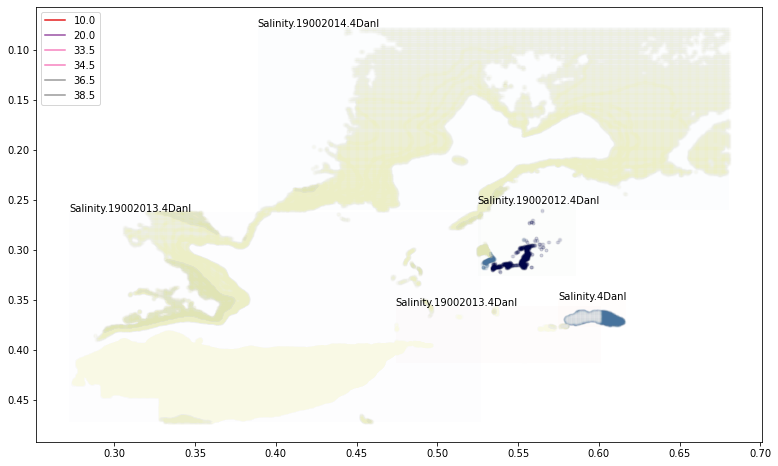

In [22]:
fig, ax = plt.subplots(figsize=(13, 8))
for result in results:

    meta, contours = result['meta'], result['contours']
    if meta['variable'] == 'Temperature':
        continue
        
    percentiles = meta['percentiles']
    N = matplotlib.colors.Normalize(np.min(percentiles), np.max(percentiles))
    
    colors = davos_map(N(meta['percentiles']))
    meta['colors'] = colors
    for color, contour, percentile in list(zip(colors, contours, percentiles)):
        df =  pd.DataFrame(contour.points, columns=['x', 'y', 'z'])
        ax.plot(df.x, df.y, '.', alpha=0.04, color=color)
    rect = np.array([
        [meta['x_min'], meta['y_min']],
        [meta['x_max'], meta['y_min']],
        [meta['x_max'], meta['y_max']],
        [meta['x_min'], meta['y_max']]
    ])
    ax.annotate(pathlib.Path(meta['path']).stem, [meta['x_min'], meta['y_min']])
    ax.fill(rect[:, 0], rect[:, 1], alpha=0.01)

    
ylim = ax.get_ylim()[::-1]
xlim = ax.get_xlim()
colors = matplotlib.cm.Set1(N(percentiles))
# render offscreen
for percentile, color in zip(percentiles, colors):
    ax.plot(0, 0, color=color, label=percentile)
# reset limits
ax.set_ylim(ylim)
ax.set_xlim(xlim)
    
ax.legend()


In [61]:
N = matplotlib.colors.Normalize(0, 20)
metas = []
for result in results:
    meta = result['meta']
    contours = result['contours']
    ds_path = pathlib.Path(meta['path'])
    base_dir = ds_path.with_suffix('') 
    base_dir.mkdir(exist_ok=True)

    meta['relative_path'] =  str(ds_path.expanduser().relative_to(data_dir.expanduser()))
    
    N = matplotlib.colors.Normalize(np.min(percentiles), np.max(percentiles))
    
    if meta['variable'] == 'Temperature':
        colors = cmocean.cm.thermal(N(meta['percentiles']))
    else:
        colors = cmocean.cm.haline(N(meta['percentiles']))
    meta['colors'] = colors
    
    paths = []

    for i, (contour, percentile) in enumerate(zip(contours, meta['percentiles'])):

        x_min = meta['x_min']
        x_max = meta['x_max']
        y_min = meta['y_min']
        y_max = meta['y_max']
        z_min = meta['z_min']
        z_max = meta['z_max']
        lat_min = meta['lat_min'] 
        lat_max = meta['lat_max'] 
        lon_min = meta['lon_min'] 
        lon_max = meta['lon_max'] 

        base_path = base_dir / "polydata-{}-{:04d}".format(meta['variable'], i)

        vtk_path = base_path.with_suffix('.vtk')
        paths.append(str(vtk_path.relative_to(data_dir.expanduser())))

#         writer = tvtk.DataSetWriter(file_name=str(vtk_path))
#         writer.add_input_data_object(contour)
#         writer.update()
#         if (writer.input.points):
#             print('min', np.min(writer.input.points, axis=0))
#             print('max', np.max(writer.input.points, axis=0))
#         writer.write()

        # Decimate and smooth

        transform_filter = tvtk.TransformFilter()
        transform = tvtk.Transform()
        transform.translate(-x_min, -y_min, -z_min)
        transform.scale(1/(x_max - x_min), 1/(y_max - y_min), 1/(z_max - z_min))
        transform_filter.transform = transform
        transform_filter.add_input_data_object(contour)
        transform_filter.update()


        # TODO: rescale all to  meters  (* 200000 for x/y)
        # and then scale back
        smooth = tvtk.SmoothPolyDataFilter()
        smooth.relaxation_factor  = 0.001
        smooth.add_input_data_object(transform_filter.output)
        smooth.update()
        
        decimate = tvtk.DecimatePro()
        decimate.add_input_data_object(smooth.output)
        decimate.target_reduction = 0.9
        decimate.preserve_topology = True
        decimate.update()
        
        transform_filter = tvtk.TransformFilter()
        transform = tvtk.Transform()
        transform.scale((x_max - x_min), (y_max - y_min), (z_max - z_min))
        transform.translate(x_min, y_min, z_min)
        transform_filter.transform = transform
        transform_filter.add_input_data_object(decimate.output)
        transform_filter.update()

        writer = tvtk.DataSetWriter(file_name=str(vtk_path))
        writer.add_input_data_object(transform_filter.output)
        writer.update()
        writer.write()


    meta['paths'] = paths

    with (base_dir / 'meta').with_suffix('.json').open('w') as f:
        pd.Series(meta).to_json(f)
    metas.append(meta)
    
pd.DataFrame(metas).to_json(data_dir / 'meta.json', orient='records')



In [53]:
transform = tvtk.Transform()
transform.translate(1, 1, 1)
transform.scale(1, 2, 1)
transform.matrix.to_array()


array([[1., 0., 0., 1.],
       [0., 2., 0., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

In [20]:
!open  $base_dir